In [23]:
import numpy as np
import matplotlib.pyplot as plt

## Load in Data

In [24]:
from boutdata import collect
from boutdata.data import BoutData
import re
import os

job_ids = [re.search('(\d){7}', dir).group() for dir in os.listdir("./shared/NORTH/") if re.search('data_(\d){7}', dir)]
job_ids.sort()
# job_id = job_ids[-1]
job_id = '5148573'
print('job_id', job_id)
path = './shared/NORTH/data_' + job_id + '/'

job_id 5148573


In [25]:
bdata = BoutData(path)
outputs = bdata['outputs']
field_keys = outputs.keys()
options = bdata['options']

/home/niflheim/s173965/.local/lib/python3.9/site-packages/boutdata/data.py:732: AlwaysWarning: While building x, y, z coordinate arrays, an exception occured: name 'mxg' is not defined
Evaluating non-scalar options not available
  alwayswarn(


In [26]:
def get_option(*keys):
    from numpy import sqrt
    val = options
    try:
        for key in keys:
            val = val[key]
        return eval(str(val))
    except:
        print('Error reading option for keys: ', keys)
        return 0

def get_options(keys_list):
    vals = []
    for keys in keys_list:
        vals.append(get_option(*keys))
    return vals

In [27]:
R, Te0, N_nuclei, mp, B0, e, mxg, myg = get_options([
    ('north', 'R'), ('north', 'Te0'), ('north', 'N_nuclei'),
    ('north', 'mp'), ('north', 'B0'), ('north', 'e'),
    (['mxg']), (['myg'])])
R, Te0, N_nuclei, mp, B0, e, mxg, myg

(0.25, 10.0, 2, 1.67e-27, 0.077, 1.6e-19, 2, 0)

In [28]:
print('nx: ', options['mesh']['nx'])
print('ny: ', options['mesh']['ny'])
print('nz: ', options['mesh']['nz'])
print('Lx: ', options['mesh']['Lx'])
print('rho_s: ', options['north']['rho_s'])
print('oci: ', options['north']['oci'])

nx:  80+2*mxg
ny:  1
nz:  256
Lx:  north:a/north:rho_s
rho_s:  sqrt(2*e*Te0/(N_nuclei*mp))/oci
oci:  e*B0/(N_nuclei*mp)


In [29]:
nx_all, ny_all, nz_all = get_options([('mesh', 'nx'),('mesh', 'ny'),('mesh', 'nz')])
oci = get_option('north', 'oci')
rho_s = get_option('north', 'rho_s')
Lx = R/rho_s * rho_s
nx_inner = nx_all - 2*mxg
ny_inner = ny_all - 2*myg
nz_inner = nz_all

In [30]:
#%% Read data

field_list  = ['T', 'n', 'phi', 'vort','source_n', 'source_T','wall_shadow']
par_list    = ['t_array']
# fast_list   = ['t_array', 'n0', 'phi0', 'n1', 'phi1', 'n2', 'phi2', 'T0', 'T1', 'T2']
#%%
data, par, fast = {}, {}, {}

for _field in field_list:
    data[_field] = collect(_field, path = path, xguards = False)

for _par in par_list:
    par[_par] = collect(_par, path = path, xguards = False)

mxsub = 2 mysub = 1 mz = 256

nxpe = 40, nype = 1, npes = 40

Reading from 0: [2-3][0-0] -> [0-1][0-0]

Reading from 1: [2-3][0-0] -> [2-3][0-0]

Reading from 2: [2-3][0-0] -> [4-5][0-0]

Reading from 3: [2-3][0-0] -> [6-7][0-0]

Reading from 4: [2-3][0-0] -> [8-9][0-0]

Reading from 5: [2-3][0-0] -> [10-11][0-0]

Reading from 6: [2-3][0-0] -> [12-13][0-0]

Reading from 7: [2-3][0-0] -> [14-15][0-0]

Reading from 8: [2-3][0-0] -> [16-17][0-0]

Reading from 9: [2-3][0-0] -> [18-19][0-0]

Reading from 10: [2-3][0-0] -> [20-21][0-0]

Reading from 11: [2-3][0-0] -> [22-23][0-0]

Reading from 12: [2-3][0-0] -> [24-25][0-0]

Reading from 13: [2-3][0-0] -> [26-27][0-0]

Reading from 14: [2-3][0-0] -> [28-29][0-0]

Reading from 15: [2-3][0-0] -> [30-31][0-0]

Reading from 16: [2-3][0-0] -> [32-33][0-0]

Reading from 17: [2-3][0-0] -> [34-35][0-0]

Reading from 18: [2-3][0-0] -> [36-37][0-0]

Reading from 19: [2-3][0-0] -> [38-39][0-0]

Reading from 20: [2-3][0-0] -> [40-41][0-0]

Reading from 

In [31]:
thetas = np.linspace(0, 2 * np.pi, nz_inner)
rhos = np.linspace(1/(2*nx_inner), Lx+1/(2*nx_inner), nx_inner)

## Plot Time Frames

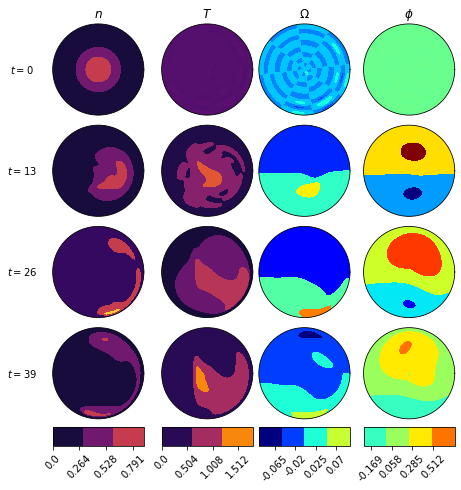

In [36]:
from matplotlib.gridspec import GridSpec

def cbar_ticks(vmin, vmax, n_ticks=4, label_rounding=2):
    ticks = np.linspace(vmin, vmax, n_ticks, endpoint=True)
    labels = np.round(ticks,3)
    return ticks, labels

def plot_time_frames():
    fields = ['n', 'T', 'vort', 'phi']
    cmaps = ['inferno', 'inferno', 'jet', 'jet']
    titles = [r'$n$', r'$T$', r'$\Omega$', r'$\phi$']
    N_frames = 4
    cm = 1/2.54 # 1 cm = 1/2.54 inch
    nrows = 5*N_frames + 1 # 5 (merged rows) for each frame plot. 1 row for colobar
    n_cols = 1 + len(fields)*3 # 1 column for each timestamp text. 3 (merged columns) for each field plot.
    fig = plt.figure(constrained_layout=True, figsize=(16*cm, 17*cm))
    gs = GridSpec(nrows, n_cols, figure=fig)
    def get_row_range(i_frame):
        return slice(5*i_frame,5*(i_frame+1))
    def get_col_range(i_field):
        return slice(1+3*i_field,1+3*(i_field+1))

    frames = np.arange(0, data[fields[0]].shape[0], int(np.ceil(data[fields[0]].shape[0]/N_frames)))

    for i_frame, frame in enumerate(frames):
        row_range = get_row_range(i_frame)
        ax = fig.add_subplot(gs[row_range, 0])
        ax.text(0.5, 0.5, r'$t = $' + str(frame), va="center", ha="center")
        plt.axis('off')

    for i_field, field in enumerate(fields):
        field_data = data[field].squeeze()
        vmin = field_data.min()
        vmax = field_data.max()
        col_range = get_col_range(i_field)
        for i_frame, frame in enumerate(frames):
            row_range = get_row_range(i_frame)
            ax = fig.add_subplot(gs[row_range, col_range], polar=True)
            if i_frame == 0:
                ax.set_title(titles[i_field])
            cont = ax.contourf(thetas, rhos, field_data[frame, :, :], 2, cmap = cmaps[i_field], vmin=vmin, vmax=vmax)
            ax.set_rticks([])
            ax.set_xticks([])

        cax = fig.add_subplot(gs[-1, col_range])
        latest = field_data[frames[-1], :, :]
        c_ticks, c_labels = cbar_ticks(latest.min(), latest.max())
        cbar = fig.colorbar(cont, cax=cax, ticks=c_ticks, orientation='horizontal')
        cbar.ax.set_xticklabels(c_labels, rotation=45)
    plt.savefig('./plots/' + job_id + '_time_frames.pdf', format="pdf", bbox_inches="tight")

plot_time_frames()

## gif Animations

In [37]:
import matplotlib.animation as animation

def animate_data(field, cmap='inferno', vmin = None, vmax = None):
    field_data = data[field].squeeze()
    if vmin is None:
        vmin = field_data.min()
    if vmax is None:
        vmax = field_data.max()
    fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
    ax.set_rticks([])
    ax.set_xticks([])
    cont = ax.contourf(thetas, rhos, field_data[0, :, :], 100, cmap = cmap, vmin=vmin, vmax=vmax)    # first image on screen
    fig.colorbar(cont, ax=ax)
    fig.tight_layout()

    # animation function
    def animate(i):
        for c in ax.collections:
            c.remove()  # removes only the contours, leaves the rest intact
        cont = ax.contourf(thetas, rhos, field_data[i, :, :], 100, cmap = cmap, vmin=vmin, vmax=vmax)
        return cont.collections
    
    anim = animation.FuncAnimation(fig, animate, frames=field_data.shape[0], interval=100, blit=True)
    anim.save('./plots/' + job_id + '_animation_' + field +'.gif', fps=4)
    plt.show()

MovieWriter ffmpeg unavailable; using Pillow instead.


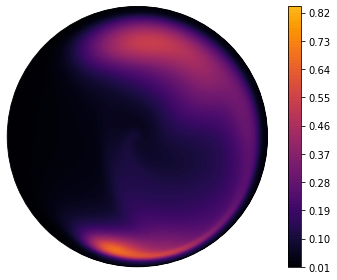

In [38]:
animate_data('n', vmin=0, vmax=1)

MovieWriter ffmpeg unavailable; using Pillow instead.


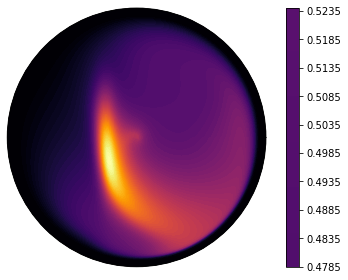

In [39]:
animate_data('T')

MovieWriter ffmpeg unavailable; using Pillow instead.


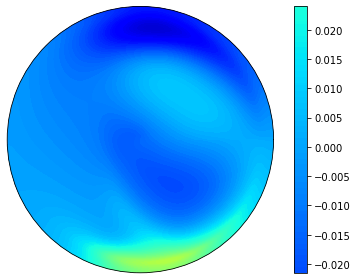

In [40]:
animate_data('vort', cmap='jet')

MovieWriter ffmpeg unavailable; using Pillow instead.


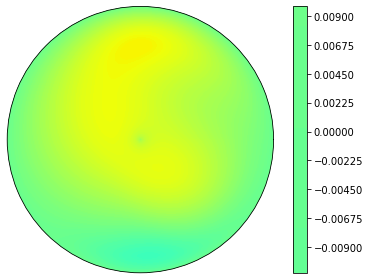

In [41]:
animate_data('phi', cmap='jet')